[55 循环神经网络 RNN 的实现](https://www.bilibili.com/video/BV1kq4y1H7sw/?spm_id_from=333.788.recommend_more_video.1)
- 本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。 我们仍然从读取时光机器数据集开始。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

- 高级API提供了循环神经网络的实现。 我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层rnn_layer。 
- 事实上，我们还没有讨论多层循环神经网络的意义（这将在 9.3节中介绍）。 
- 现在，你仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。

In [3]:

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [4]:
# 这里依旧需要手动进行初始化
# 使用张量来初始化隐状态，它的形状是（隐藏层数，批量大小，隐藏单元数）。
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

- 通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。 
- 需要强调的是，rnn_layer的“输出”（Y）不涉及输出层的计算： 它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。

In [10]:
# 输入
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# 新的输出，这里的Y输出的是隐藏层
Y, state_new = rnn_layer(X, state)
X.shape,Y.shape, state_new.shape

(torch.Size([35, 32, 28]), torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [11]:
"""
rnn与卷积神经网络的不同之处
1. 需要自己定义linear输出层,rnn只包含隐藏层
2. forward中需要自己对输入数据进行独热编码
3. forward中的输出层使用自己定义的输出层
4. rnn中需要含有初始化参数函数begin_state
"""
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
        # pytorch版本的rnn只定义了隐藏层，没有定义输出层，这里需要自己定义输出层
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [14]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller ', 10, net, vocab, device)

'time traveller qulo amfjw'

perplexity 1.0, 373008.3 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


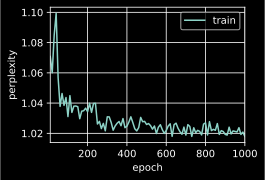

In [16]:
num_epochs, lr = 1000, 0.5
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# Q/A
- num_steps是什么
  - 句子长度（类似与序列模型的tau概念） 
- [5,2,8]处为什么要转置？
  - 主要是出于性能考虑，转置后可以连续分布与GPU
- 